In [1]:
import numpy as np
import praw
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from time import time

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import normalize
from sklearn import preprocessing
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline, make_pipeline

from gensim import corpora, models, similarities, matutils

from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

from helpers import connect, close, table_to_df
import config

%matplotlib inline

### Load datasets

The first step is to load the datasets from the database. I used sqlite3, an embedded database management system, to store my data. 

In [2]:
conn, c = connect(config.database)

### load the POSTS table into dataframe
posts = table_to_df(conn, 'POSTS')

### load the COMMENTS table into dataframe
comments_raw = table_to_df(conn, 'COMMENTS')

# convert the COMMENTS to list of strings
comments_raw['COMMENTS'] = comments_raw['COMMENTS'].map(lambda x: ast.literal_eval(x))

### Transform each element of a list-like to a row, replicating index values
comments = comments_raw.explode('COMMENTS')

close(conn)

First, we want to check if there are any NAs in the dataframes.

In [3]:
posts.isnull().sum()

id              0
title           0
score           0
subreddit       0
num_comments    0
body            0
created         0
dtype: int64

In [4]:
comments_raw.isnull().sum()

ID          0
COMMENTS    0
dtype: int64

In [65]:
comments_raw.shape

(954, 2)

Second, let us take a look at the **POSTS** table, which includes the megadata for each post.

In [64]:
# sort the dataset by data created and display the top five rows
posts.sort_values(by = ['created'], ascending = True).head(5)

,id,title,score,subreddit,num_comments,body,created
133,6bo3mk,xkcd: Machine Learning,376,datascience,20,,2017-05-17 15:33:34
135,6gi8lw,I need to print this out and put it on my cube.,367,datascience,10,,2017-06-11 03:11:17
33,713hnw,How I went from no coding or machine learning ...,628,datascience,107,TL;DR: learned a buncha shit in 20 months with...,2017-09-19 18:54:11
105,75aqpg,Impossible Job Requirements,429,datascience,54,,2017-10-09 21:40:47
68,80rhvh,newbies be like,510,datascience,130,,2018-02-28 03:05:06


Let us then take a look at the **COMMENTS** table, which includes the top comments for each post.

In [6]:
comments_raw.head(5)

,ID,COMMENTS
0,fzweaf,[This is very useful and makes me want to quit...
1,cgwvds,"[Oh hey, more awesome stuff I have no time for..."
2,aohn8w,[Tools: http://sankeymatic.com/\n\nData: Self-...
3,bupmyf,[IMO this is a large part of the reason data s...
4,drde9q,"[Honestly, if you understand the most fundamen..."


Using explode, we can transform each element of a list-like to a row, replicating index values.

In [7]:
comments.head(5)

,ID,COMMENTS
0,fzweaf,This is very useful and makes me want to quit ...
0,fzweaf,I would rename this article as my RDBMS Checkl...
0,fzweaf,"> CUSTOMER, CUSTOMER_NEW, CUSTOMER_NEW_NEW\n\n..."
0,fzweaf,"Interesting, what’s your background?"
0,fzweaf,I appreciate very much your kind gift


Calculate the length of all the comments, find the distribution of comment lengths and filter the comments by length.

In [8]:
comments['COMMENTS_LENGTH'] = comments['COMMENTS'].str.split().str.len().fillna(0).astype(int)

In [9]:
print('The mean of the length of the comments is {}.'.format(comments['COMMENTS_LENGTH'].mean()))
print('The median of the length of the comments is {}.'.format(comments['COMMENTS_LENGTH'].median()))
print('The standard deviation of the length of the comments is {}.'.format(comments['COMMENTS_LENGTH'].std()))

The mean of the length of the comments is 58.21530180699731.
The median of the length of the comments is 29.0.
The standard deviation of the length of the comments is 83.13319961716927.


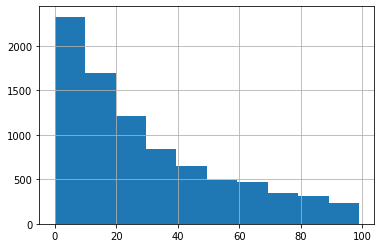

In [10]:
comments[comments['COMMENTS_LENGTH'] < 100]['COMMENTS_LENGTH'].hist()

### looking at everything below 28, look at different bins; 
### what seems to be consistent. what sort of scaling would you want to consider? take a look at the terms. power transform/log transform
### as the weight? Consider something

In [11]:
## the proportion of comments shorter than 100 words
(comments[comments['COMMENTS_LENGTH'] < 100].shape[0])/(len(comments['COMMENTS']))

0.8259323337178008

In [12]:
## the proportion of comments longer than 100 words
(comments[comments['COMMENTS_LENGTH'] >= 100].shape[0])/(len(comments['COMMENTS']))

0.17406766628219916

In [13]:
comments_short = comments.query('COMMENTS_LENGTH >0 & COMMENTS_LENGTH < 100')[['ID', 'COMMENTS']].groupby('ID').agg(lambda x: x.tolist())
comments_short.head()

,COMMENTS
ID,
6bo3mk,[This is henceforth going to be a slide in eve...
6gi8lw,[apology for poor english\n\nwhere were you wh...
713hnw,[You greatly underestimate the value of your m...
75aqpg,"[What, no PhD requirement to go along with it?..."
80rhvh,[Seems like this ended up being a good opportu...


In [14]:
comments_long = comments.query('COMMENTS_LENGTH > 100')[['ID', 'COMMENTS']].groupby('ID').agg(lambda x: x.tolist())
comments_long.head()

,COMMENTS
ID,
713hnw,[>The name of the school and the operations re...
80rhvh,"[Man, every time I see a post like this it jus..."
8nl2ps,[Years ago I worked at a headhunter and saw ho...
9f18t6,[This is why I have no interest in socializing...
9lprhw,[I was in a class like this for computer archi...


### Preprocessing

In [15]:
###
import re
def preprocessing(df):
    ## Join the list of string into one long string:
    df['COMMENTS'] = df['COMMENTS'].str.join(' ')

    ## Remove empty space:
    df['COMMENTS'] = df['COMMENTS'].map(lambda x: re.sub('\s+', ' ', x))

    ## Convert all string to lower cases:
    df['COMMENTS'] = df['COMMENTS'].str.lower()

    ## Remove all the punctuations:
    df['COMMENTS'] = df['COMMENTS'].map(lambda x: re.sub('[^\w\s]', '', x))
    
    return df

In [16]:
comments_raw = preprocessing(comments_raw)
comments_raw.head()

,ID,COMMENTS
0,fzweaf,this is very useful and makes me want to quit ...
1,cgwvds,oh hey more awesome stuff i have no time for ...
2,aohn8w,tools httpsankeymaticcom data selfgathered dat...
3,bupmyf,imo this is a large part of the reason data sc...
4,drde9q,honestly if you understand the most fundamenta...


In [17]:
comments_short = preprocessing(comments_short)
comments_short.head()

,COMMENTS
ID,
6bo3mk,this is henceforth going to be a slide in ever...
6gi8lw,apology for poor english where were you when c...
713hnw,you greatly underestimate the value of your ma...
75aqpg,what no phd requirement to go along with it de...
80rhvh,seems like this ended up being a good opportun...


In [18]:
comments_long = preprocessing(comments_long)
comments_long.head()

,COMMENTS
ID,
713hnw,the name of the school and the operations rese...
80rhvh,man every time i see a post like this it just ...
8nl2ps,years ago i worked at a headhunter and saw how...
9f18t6,this is why i have no interest in socializing ...
9lprhw,i was in a class like this for computer archit...


Next, we need to define the stemmer, tokenizer and the stop_words.

In [20]:
nltk_stop_words = stopwords.words('english')

more_stop_words = ['could', 'really', 'would','one','also','days', 
                  'say', 'can', 'id', 'ive', 'arent', 'something', 'many', 'etc', 'even', 
                   'like', 'just', 'im', 'dont', 'youre', 'great', 'nice', 'good', 'data', 'thank', 'lol']

stop_words = nltk_stop_words + more_stop_words

# define the Stemmer
stemmer = SnowballStemmer('english')

stop_words = [stemmer.stem(word) for word in stop_words]

# define the Tokenizer
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize_and_stem(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text)]

def tokenize_only(text):
    return tokenizer.tokenize(text)

In [23]:
comms_short = comments_short['COMMENTS'].values

comms_long = comments_long['COMMENTS'].values

comms = comments_raw['COMMENTS'].values

# # tokenize only, no stemmize
# # max_features = 500: only consider the top max_features ordered by term frequency
# vectorizer1 = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize_only, max_features = 200)
# X1 = vectorizer1.fit_transform(comms)
# X1_norm = normalize(X1)
# words1 = vectorizer1.get_feature_names()

# tokenize and stemmize
# max_features = 500: only consider the top max_features ordered by term frequency
vectorizer = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize_and_stem, max_features = 200)
X_short = vectorizer.fit_transform(comms_short)
X_short_norm = normalize(X_short)
words_short = vectorizer.get_feature_names()
### try the raw count to compare with tfidf. 

### try to get some non-NLP, more statistical test. 

In [24]:
vectorizer = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize_and_stem, max_features = 200)
X_long = vectorizer.fit_transform(comms_long)
X_long_norm = normalize(X_long)
words_long = vectorizer.get_feature_names()

In [25]:
vectorizer = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize_and_stem, max_features = 200)
X = vectorizer.fit_transform(comms)
X_norm = normalize(X)
words = vectorizer.get_feature_names()

### K-means

In [26]:
# for X_short
kmeans_5 = KMeans(n_clusters = 5, n_init = 5, n_jobs = -1)
kmeans_5.fit(X_short)

common_words = kmeans_5.cluster_centers_.argsort()[:,-1:-12:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words_short[word] for word in centroid))

0 : get, look, work, want, need, go, make, cours, know, project, think
1 : interview, job, get, role, compani, ds, scienc, ask, posit, work, question
2 : scienc, work, learn, scientist, job, get, know, peopl, engin, time, compani
3 : use, model, work, featur, predict, need, tri, notebook, make, get, look
4 : r, python, use, languag, sas, code, learn, work, sql, panda, need


In [27]:
# for X_long
kmeans_5 = KMeans(n_clusters = 5, n_init = 5, n_jobs = -1)
kmeans_5.fit(X_long)

common_words = kmeans_5.cluster_centers_.argsort()[:,-1:-12:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words_long[word] for word in centroid))

0 : r, python, use, languag, learn, tool, sql, know, excel, work, peopl
1 : use, get, work, peopl, make, time, code, need, project, thing, want
2 : model, use, featur, predict, train, learn, problem, need, custom, work, time
3 : scienc, job, program, learn, work, get, math, degre, scientist, year, cours
4 : compani, work, job, get, team, manag, peopl, scientist, ds, scienc, time


### Optimal Number of Clusters

When we use K-means method, one of the things we need to do is to choose the optimal number of clusters. We don't want to choose too few clusters, as they will group data with significant differences together; nor do we want to have to many clusters, as it will cause overfitting. To find the optimal number of clusters, we resort to elbow method. It involves estimating the model using various numbers of clusters and calculating the negative of the within-cluster sum of squares for each number of clusters chosen using the score method from sklearn. 

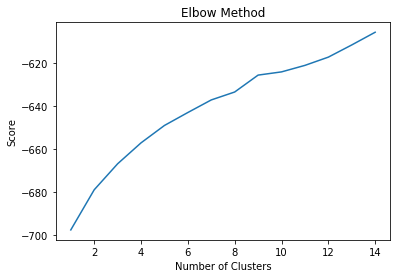

In [28]:
# find the optimal number of clusters for X_short
number_clusters = range(1, 15)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(X_short).score(X_short) for i in range(len(kmeans))]
score

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()


### hierachical clustering 8 and 12 dandrogram top 50 tokens

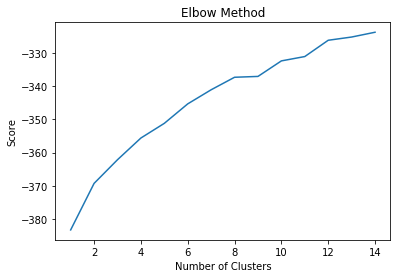

In [29]:
# find the optimal number of clusters for X_long
number_clusters = range(1, 15)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(X_long).score(X_long) for i in range(len(kmeans))]
score

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

### hierachical clustering 8 dandrogram top 50 tokens

#### Visualize the clusters

In [ ]:
from sklearn.decomposition import PCA

sklearn_pca = PCA(n_components = 2)
X1_pca = sklearn_pca.fit_transform(X1)
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(X1_pca)
prediction = kmeans.predict(X1_pca)

plt.scatter(X1_pca[:, 0], X1_pca[:, 1], c=predicted_values, s=50, cmap='viridis')

centers = fitted.centroids
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

In [ ]:
sklearn_pca = PCA(n_components = 2)
X3_pca = sklearn_pca.fit_transform(X3)

### Performing dimensionality reduction using LSA

Vectorizer results are normalized, which makes KMeans behave as spherical k-means for better results. Since LSA/SVD results are not normazlied, we need to redo the normalization.

In [30]:
# for X1
SVD = TruncatedSVD(n_components = 10)
normalizer = preprocessing.Normalizer(copy = False)
lsa = make_pipeline(SVD, normalizer)
X = lsa.fit_transform(X_short)

AttributeError: 'function' object has no attribute 'Normalizer'

Which component explains the variance the most?

In [ ]:
X[0], SVD.explained_variance_ratio_

#### Explained variance with different number of components.

In [ ]:
# for X1
for i in range(1,15):
    t0 = time()
    
    svd = TruncatedSVD(n_components=i)
    normalizer = preprocessing.Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X1)

    print("done in %fs" % (time() - t0))

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

In [ ]:
# for X2
for i in range(1,15):
    t0 = time()
    
    svd = TruncatedSVD(n_components=i)
    normalizer = preprocessing.Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X2)

    print("done in %fs" % (time() - t0))

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

Export TFIDF vectors to gensim and let it know the mapping of row index to term:
- Convert sparse matrix of counts to a gensim corpus
- Transpose it for gensim -> needs to be terms by docs instead of docs by terms

In [31]:
# for X_short
tfidf_corpus1 = matutils.Sparse2Corpus(X_short.transpose())

# Row indices
id2word1 = dict((v, k) for k, v in vectorizer.vocabulary_.items())

id2word1 = corpora.Dictionary.from_corpus(tfidf_corpus1, 
                                         id2word=id2word1)

In [32]:
# for X_long
tfidf_corpus2 = matutils.Sparse2Corpus(X_long.transpose())

# Row indices
id2word2 = dict((v, k) for k, v in vectorizer.vocabulary_.items())

id2word2 = corpora.Dictionary.from_corpus(tfidf_corpus2, 
                                         id2word=id2word2)

### LSA/LSI in gensim
Build an LSI space from the input TFIDF matrix, mapping of row id to word, and num_topics.
num_topics is the number of dimensions to reduce to after the SVD.
Same as "fit" in sklearn, it primes an LSI space.

In [33]:
# for X1
lsi = models.LsiModel(tfidf_corpus1, id2word=id2word1, num_topics=6)
lsi.show_topics(300,15,formatted=False)

[(0,
  [('valu', 0.25102087459497263),
   ('write', 0.21411702695161713),
   ('school', 0.18425912813997317),
   ('general', 0.1784510282713659),
   ('job', 0.15958458789071867),
   ('less', 0.15760089452374013),
   ('month', 0.1462110779890985),
   ('knowledg', 0.13985268341730112),
   ('train', 0.13886525211057224),
   ('lot', 0.1341174428143345),
   ('peopl', 0.12817089713680382),
   ('need', 0.12800908913101908),
   ('manag', 0.12406546657881577),
   ('though', 0.12315153143189651),
   ('way', 0.11823783740421281)]),
 (1,
  [('valu', -0.5521490603626135),
   ('question', -0.26215653739111666),
   ('read', -0.26032216832659927),
   ('month', -0.250959929936329),
   ('job', 0.246273485056497),
   ('school', 0.18986565804830713),
   ('scienc', 0.16106950166604941),
   ('come', 0.13668739304605124),
   ('ds', 0.136630066627096),
   ('interview', 0.13276868357082838),
   ('result', 0.1278853238355486),
   ('math', 0.12119492672902045),
   ('degre', 0.11485112055454096),
   ('engin', 0.1

In [34]:
# for X2
lsi = models.LsiModel(tfidf_corpus2, id2word=id2word2, num_topics=6)
lsi.show_topics(300,15,formatted=False)

#### DISTANCE METRIC. Intre vs Inter

[(0,
  [('work', 0.22358254110002737),
   ('us', 0.18381595324184039),
   ('go', 0.1823912020032431),
   ('role', 0.17292972509071147),
   ('kind', 0.1660798838381102),
   ('level', 0.15308706323808907),
   ('part', 0.14903378910913048),
   ('model', 0.14866652607769593),
   ('compani', 0.1477508012570105),
   ('time', 0.13678436164495184),
   ('need', 0.13301605616898882),
   ('manag', 0.12467245860014585),
   ('think', 0.12423360397779418),
   ('languag', 0.12002178897454549),
   ('hard', 0.11761683530067796)]),
 (1,
  [('model', 0.43024601920431343),
   ('us', 0.3506313894293377),
   ('kind', -0.27573438079847096),
   ('role', -0.23365135966037462),
   ('field', 0.21492158034686737),
   ('compani', -0.16684885880804964),
   ('posit', 0.15321526268319383),
   ('ds', -0.13939669258532683),
   ('problem', -0.13517227413299335),
   ('dataset', 0.1314939463791949),
   ('degre', -0.1305545193792542),
   ('run', -0.12979360364753068),
   ('put', 0.1287216897953656),
   ('research', -0.1255

Project the tfidf vectors onto the first N principal components. Significantly fewer features than the original tfidf vector, but they are stronger features, and the accuracy is higher. 

In [35]:
# for X1
svd_test = TruncatedSVD(10)
lsa_test = make_pipeline(svd_test, preprocessing.Normalizer(copy=False))
feat_names = vectorizer.get_feature_names()

X_train_lsa = lsa_test.fit_transform(X_short)

# The SVD matrix will have one row per component, and one column per feature
# of the original data.

for component_num in range(0, 5):

    comp = svd_test.components_[component_num]
    
    # Sort the weights in the first component, and get the indeces.
    indeces = np.argsort(comp).tolist()
    
    # Get largest weights first.
    indeces.reverse()
    
    # Get top 10 terms with highest weight in this component.        
    terms = [feat_names[weightIndex] for weightIndex in indeces[0:10]]    
    weights = [comp[weightIndex] for weightIndex in indeces[0:10]]    
   
    # Plot terms and weights as a horizontal bar graph.    
    # The horizontal bar graph displays the first item on the bottom; reverse
    # the order of the terms so the biggest one is on top.
    terms.reverse()
    weights.reverse()
    positions = range(10)    # the bar centers on the y axis
    
    plt.figure(component_num)
    plt.barh(positions, weights, align='center')
    plt.yticks(positions, terms)
    plt.xlabel('Weight')
    plt.title('Strongest terms for component %d' % (component_num))
    plt.grid(True)
    plt.show()

AttributeError: 'function' object has no attribute 'Normalizer'

In [ ]:
# for X2
svd_test = TruncatedSVD(10)
lsa_test = make_pipeline(svd_test, preprocessing.Normalizer(copy=False))
feat_names = vectorizer2.get_feature_names()

X_train_lsa = lsa_test.fit_transform(X_long)

# The SVD matrix will have one row per component, and one column per feature
# of the original data.

for component_num in range(0, 5):

    comp = svd_test.components_[component_num]
    
    # Sort the weights in the first component, and get the indeces.
    indeces = np.argsort(comp).tolist()
    
    # Get largest weights first.
    indeces.reverse()
    
    # Get top 10 terms with highest weight in this component.        
    terms = [feat_names[weightIndex] for weightIndex in indeces[0:10]]    
    weights = [comp[weightIndex] for weightIndex in indeces[0:10]]    
   
    # Plot terms and weights as a horizontal bar graph.    
    # The horizontal bar graph displays the first item on the bottom; reverse
    # the order of the terms so the biggest one is on top.
    terms.reverse()
    weights.reverse()
    positions = range(10)    # the bar centers on the y axis
    
    plt.figure(component_num)
    plt.barh(positions, weights, align='center')
    plt.yticks(positions, terms)
    plt.xlabel('Weight')
    plt.title('Strongest terms for component %d' % (component_num))
    plt.grid(True)
    plt.show()
    
### top x bigrams

### filter samples by the number of tokens. how many tokens is total after. distribution

### Latent Semantic Analysis

In [36]:
from sklearn.decomposition import TruncatedSVD

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=6, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X_short)

len(svd_model.components_)

6

In [38]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        #print(t[0])
        print(t)
        print(" ")

Topic 0: 
('valu', 0.2510219643418864)
 
('write', 0.2141194641749164)
 
('school', 0.1842608626170733)
 
('general', 0.17845745577294306)
 
('job', 0.15958326983291687)
 
('less', 0.15760514390115193)
 
('month', 0.14621205425967185)
 
Topic 1: 
('valu', 0.5522456810880885)
 
('question', 0.2618478287120751)
 
('read', 0.2605043221169908)
 
('month', 0.25100284581773796)
 
('notebook', 0.11054100667741278)
 
('chang', 0.11015997811252881)
 
('open', 0.10533410100158537)
 
Topic 2: 
('read', 0.4437968139190086)
 
('question', 0.44270989545906875)
 
('consid', 0.17620140471812795)
 
('learn', 0.15427695382610698)
 
('specif', 0.14102695683341585)
 
('less', 0.1391652916503286)
 
('run', 0.11455534635941948)
 
Topic 3: 
('month', 0.5695743597238199)
 
('read', 0.2710868860616366)
 
('question', 0.21150616893221483)
 
('less', 0.2062637066854733)
 
('stat', 0.1755697640154135)
 
('school', 0.14168890570351894)
 
('pretti', 0.1289933009557725)
 
Topic 4: 
('consid', 0.4353643485213028)
 
(

In [ ]:
#import umap
import umap.umap_ as umap

X_topics = svd_model.fit_transform(X1)
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics)

plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], 
#c = dataset.target,
s = 10, # size
edgecolor='none'
)
plt.show()

In [ ]:
### after token, stem, do a counter vectorizer or sum the tokens for each row. what's the length of the row. take a look at the distribution. plot. think about the weighting. 
### we want to remove the outlier counts. a normalized length for each comment. remove super short/long comments. it will add some bias. 
### medium comment/short comment/long comment similarity. 

### Frequency Study

In [51]:
import nltk
from nltk.tokenize import word_tokenize 
from nltk.collocations import BigramCollocationFinder

stop_words = nltk_stop_words + more_stop_words
comments_raw['COMMENTS'] = comments_raw['COMMENTS'].map(lambda text: " ".join(word for word in text.split() if word not in stop_words))
text = ' '.join(comments_raw['COMMENTS'])

bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(word_tokenize(text))
    
for k,v in sorted(finder.ngram_fd.items(), key=lambda item: item[1], reverse=True):
    if v > 30:
        print(k, v)

('machine', 'learning') 374
('r', 'python') 129
('make', 'sure') 125
('deep', 'learning') 119
('software', 'engineering') 118
('python', 'r') 109
('computer', 'science') 107
('entry', 'level') 97
('can', 'not') 95
('years', 'ago') 88
('get', 'job') 85
('linear', 'regression') 81
('use', 'python') 78
('years', 'experience') 76
('5', 'years') 73
('pretty', 'much') 70
('10', 'years') 69
('lot', 'people') 68
('open', 'source') 68
('domain', 'knowledge') 68
('need', 'know') 67
('linear', 'algebra') 67
('thanks', 'sharing') 66
('use', 'r') 62
('work', 'experience') 62
('time', 'series') 61
('real', 'world') 60
('2', 'years') 59
('make', 'sense') 58
('hiring', 'manager') 58
('masters', 'degree') 57
('web', 'scraping') 56
('first', 'job') 55
('gon', 'na') 55
('logistic', 'regression') 50
('much', 'better') 50
('full', 'time') 49
('problem', 'solving') 49
('grad', 'school') 49
('3', 'years') 48
('software', 'engineer') 48
('go', 'back') 48
('jupyter', 'notebook') 47
('random', 'forest') 47
('so

In [46]:
comments_short['COMMENTS'] = comments_short['COMMENTS'].map(lambda text: " ".join(word for word in text.split() if word not in stop_words))
text = ' '.join(comments_short['COMMENTS'])


bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(word_tokenize(text))
    
for k,v in sorted(finder.ngram_fd.items(), key=lambda item: item[1], reverse=True):
    if v > 20:
        print(k, v)

('machine', 'learning') 155
('thanks', 'sharing') 65
('r', 'python') 53
('deep', 'learning') 52
('python', 'r') 51
('entry', 'level') 50
('software', 'engineering') 49
('can', 'not') 42
('gon', 'na') 39
('linear', 'algebra') 39
('years', 'ago') 38
('time', 'series') 38
('linear', 'regression') 36
('open', 'source') 35
('get', 'job') 34
('pretty', 'much') 34
('years', 'experience') 33
('masters', 'degree') 31
('5', 'years') 30
('logistic', 'regression') 30
('need', 'know') 29
('jupyter', 'notebook') 29
('computer', 'science') 29
('real', 'world') 29
('use', 'python') 28
('make', 'sure') 28
('work', 'experience') 27
('lot', 'people') 27
('jupyter', 'notebooks') 27
('much', 'better') 26
('software', 'engineer') 26
('first', 'job') 26
('use', 'r') 25
('job', 'market') 25
('10', 'years') 24
('3', 'years') 23
('soft', 'skills') 23
('open', 'office') 23
('2', 'years') 22
('didnt', 'know') 22
('domain', 'knowledge') 22
('learning', 'science') 21
('programming', 'language') 21


In [47]:
comments_long['COMMENTS'] = comments_long['COMMENTS'].map(lambda text: " ".join(word for word in text.split() if word not in stop_words))
text = ' '.join(comments_long['COMMENTS'])


bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(word_tokenize(text))
    
for k,v in sorted(finder.ngram_fd.items(), key=lambda item: item[1], reverse=True):
    if v > 20:
        print(k, v)

('machine', 'learning') 217
('make', 'sure') 97
('computer', 'science') 77
('r', 'python') 75
('software', 'engineering') 68
('deep', 'learning') 67
('python', 'r') 59
('can', 'not') 53
('get', 'job') 51
('use', 'python') 50
('years', 'ago') 49
('entry', 'level') 47
('domain', 'knowledge') 46
('10', 'years') 45
('linear', 'regression') 45
('5', 'years') 43
('years', 'experience') 43
('web', 'scraping') 42
('lot', 'people') 41
('hiring', 'manager') 40
('need', 'know') 38
('make', 'sense') 38
('use', 'r') 37
('2', 'years') 37
('random', 'forest') 37
('pretty', 'much') 36
('problem', 'solving') 34
('work', 'experience') 34
('go', 'back') 33
('open', 'source') 33
('grad', 'school') 33
('software', 'engineers') 32
('6', 'months') 32
('feature', 'engineering') 32
('little', 'bit') 31
('doesnt', 'matter') 31
('real', 'world') 31
('masters', 'science') 30
('neural', 'networks') 30
('much', 'easier') 30
('first', 'job') 29
('pandas', 'numpy') 29
('high', 'level') 29
('linear', 'algebra') 28
('e

In [63]:
from nltk.probability import FreqDist # this also uses Counter. 


unigram_list = FreqDist(' '.join(comments_raw['COMMENTS']).split()).most_common(1000)
#' '.join(ds_comments_raw['Comments']).split()

unigram_df = pd.DataFrame(unigram_list, columns=["Word", "Frequency"])
unigram_df[unigram_df['Word'] == 'bootcamp']

,Word,Frequency
793,bootcamp,72


In [49]:
from nltk.probability import FreqDist # this also uses Counter. 


unigram_list = FreqDist(' '.join(comments_short['COMMENTS']).split()).most_common(100)
#' '.join(ds_comments_raw['Comments']).split()

unigram_df = pd.DataFrame(unigram_list, columns=["Word", "Frequency"])
unigram_df.head(20)

,Word,Frequency
0,science,1056
1,work,884
2,get,809
3,use,711
4,know,676
5,python,668
6,people,665
7,job,662
8,time,614
9,r,575


In [50]:
from nltk.probability import FreqDist # this also uses Counter. 


unigram_list = FreqDist(' '.join(comments_long['COMMENTS']).split()).most_common(100)
#' '.join(ds_comments_raw['Comments']).split()

unigram_df = pd.DataFrame(unigram_list, columns=["Word", "Frequency"])
unigram_df.head(20)

,Word,Frequency
0,work,1291
1,science,1222
2,get,1144
3,people,1050
4,job,914
5,time,908
6,think,824
7,need,792
8,use,779
9,python,776


12/04/20
Take a look at the bootcamp comments for the last six months (check the data source)| or 3 months
Generate a report for marketing. 

In [54]:
'bootcamp' ' '.join(comments_raw['COMMENTS'])

True